In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

INPUT_DIR = './free-spoken-digit-dataset-master/recordings/'
OUTPUT_DIR = './outputDir/working/'

parent_list = os.listdir(INPUT_DIR)
for i in range(10):
    if i == 0:
        continue
    else:
        print(parent_list[i])   


0_george_0.wav
0_george_1.wav
0_george_10.wav
0_george_11.wav
0_george_12.wav
0_george_13.wav
0_george_14.wav
0_george_15.wav
0_george_16.wav


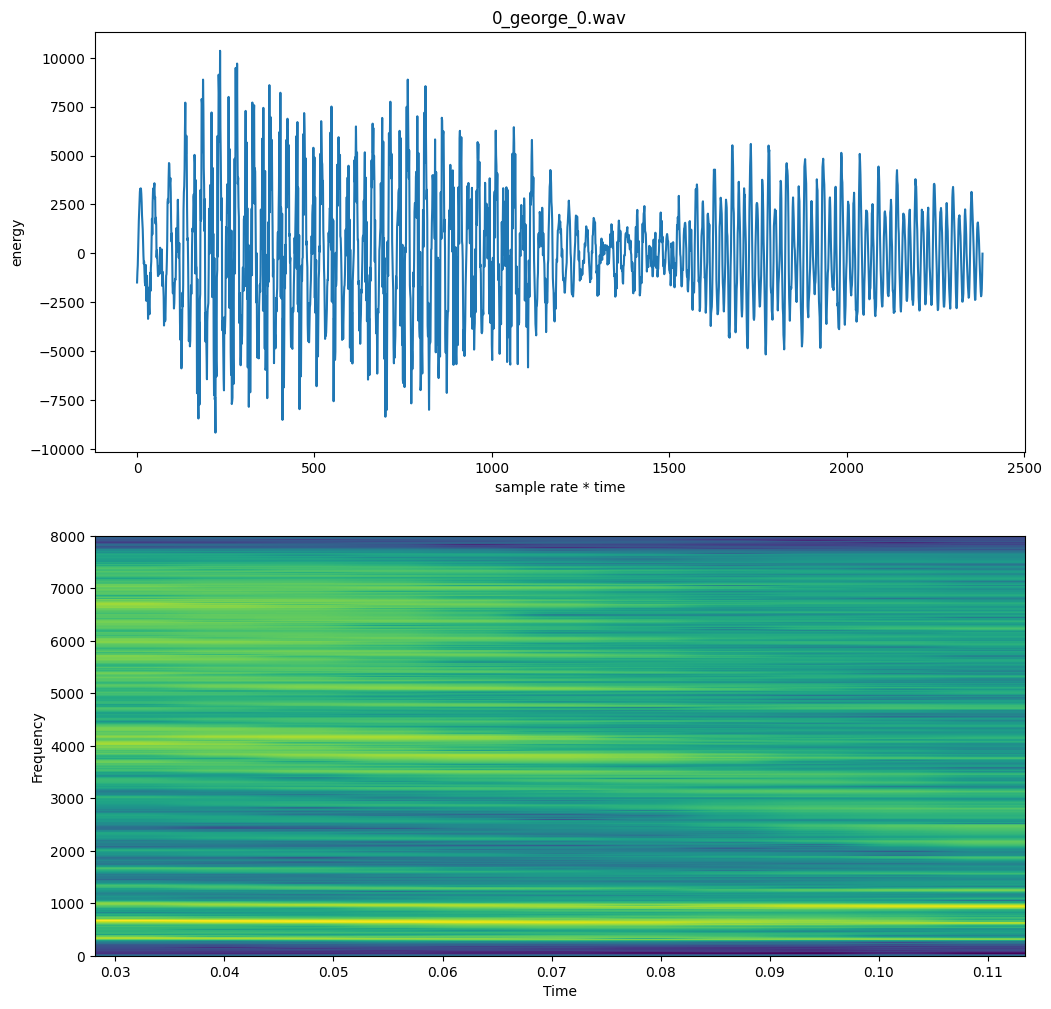

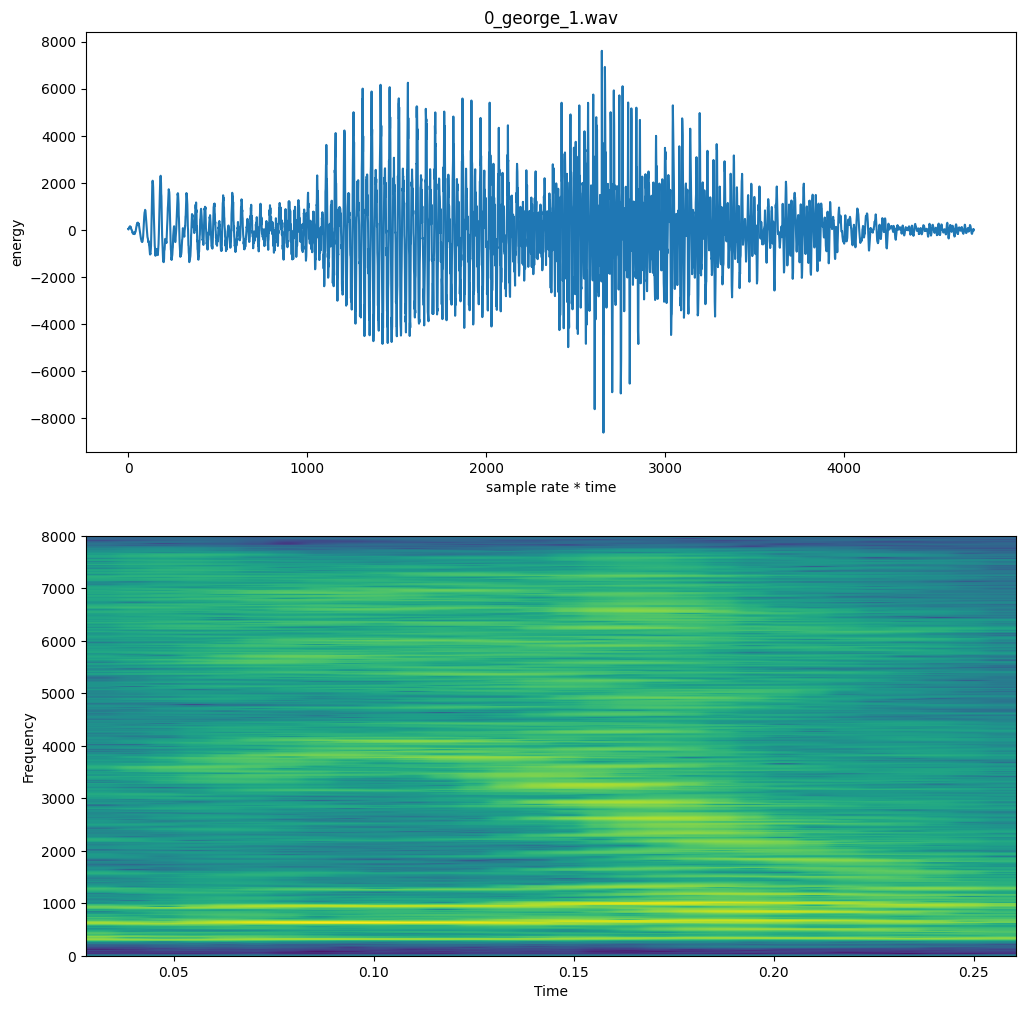

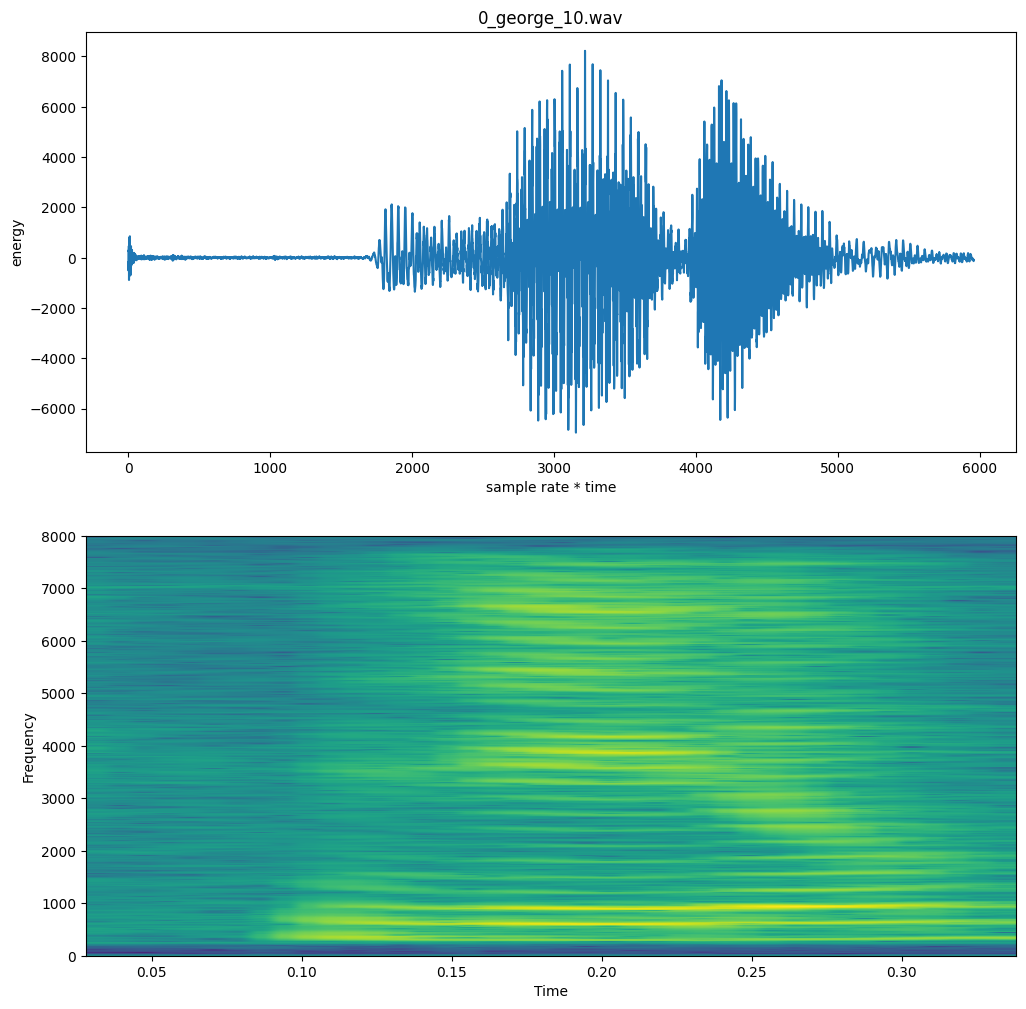

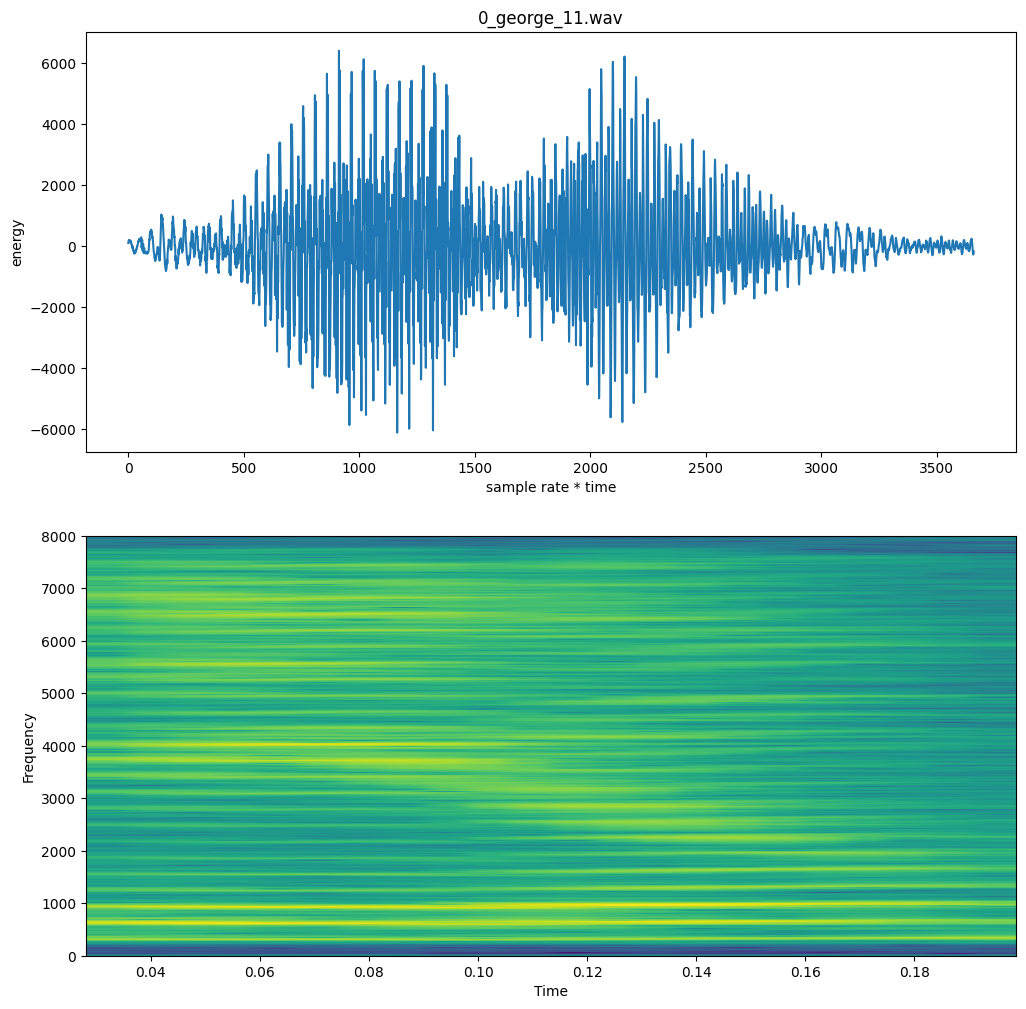

In [3]:
for i in range(5):
    if i == 0:  continue
    signal_wave = wave.open(os.path.join(INPUT_DIR,parent_list[i]),'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate),dtype=np.int16)


    plt.figure(figsize=(12,12))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')


    plot_b = plt.subplot(212)
    plot_b.specgram(sig,NFFT=1024,Fs=sample_rate,noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()  
    

In [4]:
def get_wav_info(wav_file):
    wav = wave.open(wav_file,'r')
    frames= wav.readframes(-1)
    sound_info = pylab.frombuffer(frames,'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info,frame_rate

if not os.path.exists(os.path.join(OUTPUT_DIR,'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR,'audio-images'))

for filename in os.listdir(INPUT_DIR):
    if "wav" in filename:
        file_path = os.path.join(INPUT_DIR,filename)
        file_stem = Path(file_path).stem
        target_dir = f'class_{file_stem[0]}'
        dist_dir = os.path.join(os.path.join(OUTPUT_DIR,'audio-images'),target_dir)
        file_dist_path = os.path.join(dist_dir,file_stem)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            sound_info,frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info,Fs=frame_rate)
            pylab.savefig(f'{file_dist_path}.png')
            pylab.close()

path_list = os.listdir(os.path.join(OUTPUT_DIR,'audio-images'))
print("Classes: \n")
for i in range(10):
    print(path_list[i])

path_list = os.listdir(os.path.join(OUTPUT_DIR,'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])   
    

Classes: 

class_0
class_1
class_2
class_3
class_4
class_5
class_6
class_7
class_8
class_9

A few example files: 

1_george_0.png
1_george_1.png
1_george_10.png
1_george_11.png
1_george_12.png
1_george_13.png
1_george_14.png
1_george_15.png
1_george_16.png
1_george_17.png


In [5]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE,validation_split=0.2,directory=os.path.join(OUTPUT_DIR,'audio-images'),shuffle=True,color_mode='rgb',image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),subset="training",seed=0)
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE,validation_split=0.2,directory=os.path.join(OUTPUT_DIR,'audio-images'),shuffle=True,color_mode='rgb',image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),subset="validation",seed=0)

Found 2994 files belonging to 10 classes.
Using 2396 files for training.
Found 2994 files belonging to 10 classes.
Using 598 files for validation.


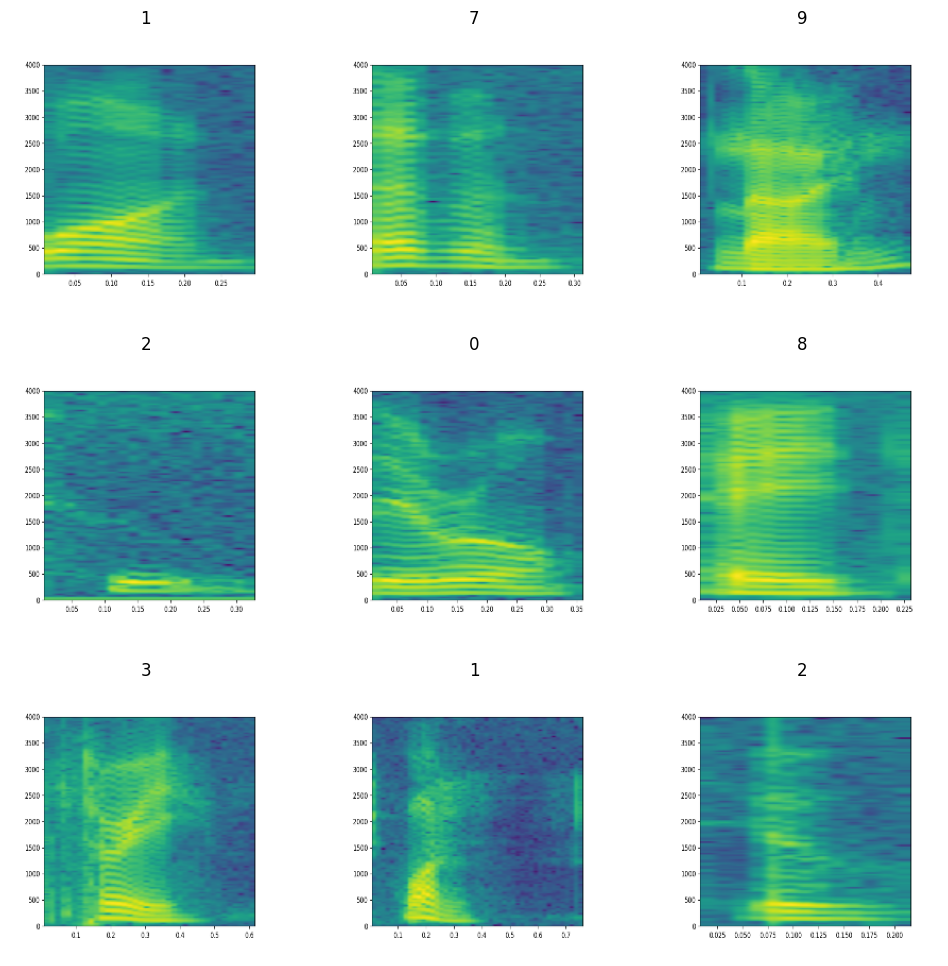

In [6]:
plt.figure(figsize=(12,12))
for images,labels in train_dataset.take(1):
    
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

plt.show()

In [7]:
def prepare(ds,augment=False):
    rescale = tf.keras.Sequential([tf.keras.layers.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal_and_vertical"),
                                          tf.keras.layers.RandomRotation(0.2)])

    ds = ds.map(lambda x,y: (rescale(x,training=True),y))
    if augment: ds= ds.map(lambda x,y: (flip_and_rotate(x,training=True),y))

train_set= prepare(train_dataset,augment=True)
test_set = prepare(valid_dataset,augment=False)

In [9]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32,3,strides=2,padding='same',activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
history = model.fit(train_dataset,epochs=10,validation_data=valid_dataset)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.6282 - loss: 1.2909 - val_accuracy: 0.2625 - val_loss: 3.9754
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9328 - loss: 0.2341 - val_accuracy: 0.7241 - val_loss: 0.7880
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9592 - loss: 0.1420 - val_accuracy: 0.9147 - val_loss: 0.2688
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9701 - loss: 0.1017 - val_accuracy: 0.9331 - val_loss: 0.2236
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9883 - loss: 0.0489 - val_accuracy: 0.9164 - val_loss: 0.2785
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9912 - loss: 0.0350 - val_accuracy: 0.9548 - val_loss: 0.1273
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9949 - loss: 0.0256 - val_accuracy: 0.9498 - val_loss: 0.1648
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9963 - loss: 0.0193 - val_accuracy: 0.9699 - val_lo

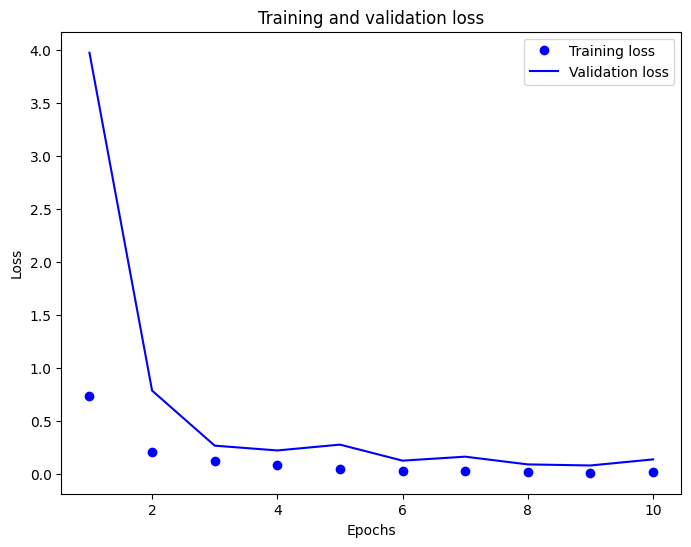

In [11]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1,len(loss_values)+1)

plt.figure(figsize=(8,6))

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


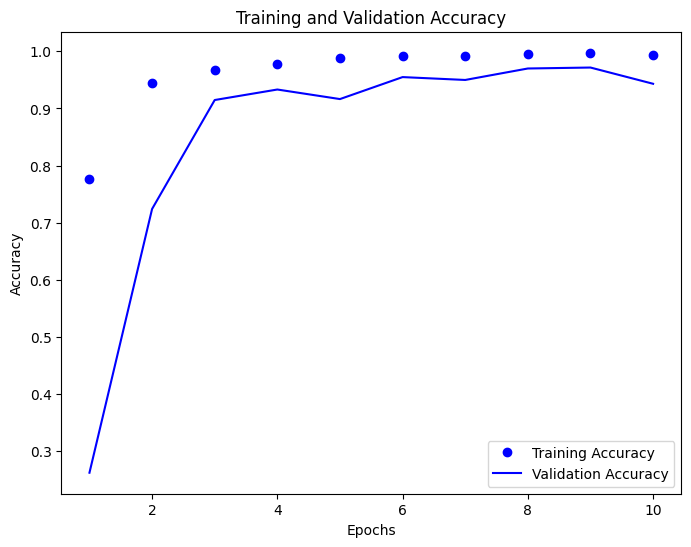

In [12]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1,len(acc_values)+1)
plt.figure(figsize=(8,6))
plt.plot(epochs,acc_values,'bo',label='Training Accuracy')
plt.plot(epochs,val_acc_values,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
final_loss,final_accuracy = model.evaluate(valid_dataset,verbose=0)
print("Final Loss: {0:.6f}, Final Accuracy: {1:.6f}".format(final_loss,final_accuracy))

Final Loss: 0.139235, Final Accuracy: 0.943144
